#Run pre-trained BERT model for text classification
Code in this file is derived from the following BERT tutorial: https://colab.research.google.com/drive/1ywsvwO6thOVOrfagjjfuxEf6xVRxbUNO#scrollTo=oCYZa1lQ8Jn8

In [51]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt
import os
from utils_text_clf import utils_text_clf as utils
import pandas as pd

device = torch.device("cpu")
n_gpu = torch.cuda.device_count()

Load data

In [52]:
data_dir = os.path.join(os.getcwd(),'data')
filename = 'train.jsonl'
file = os.path.join(data_dir, filename)  # .json file
train_df = utils.parse_json(file)

test_filename = 'test.jsonl'
test_file = os.path.join(data_dir, test_filename)  # .json file
test_df = utils.parse_json(test_file)

Format data for feeding into BERT model

In [53]:
train_tweets = train_df.response.values
# We need to add special tokens at the beginning and end of each tweet for BERT to work properly
train_tweets = ["[CLS] " + tweet + " [SEP]" for tweet in train_tweets]
train_df["label"] = (train_df.label == 'SARCASM').astype(int)
train_labels = train_df.label.values

Tokenize training data using BERT pre-trained tokenizer

In [54]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_tweets = [tokenizer.tokenize(tweet) for tweet in train_tweets]

Recommended make length of squences of tokens, each sequence is either padded or cut to fit this length

In [55]:
MAX_LEN = 128

In [56]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(tweet) for tweet in tokenized_tweets]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

Attention Masks to indicate what is part of the tweet and what is padding

In [57]:
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i > 0) for i in seq]
    attention_masks.append(seq_mask)

Split train data into train and validation for fitting the model

In [58]:
x_train, x_val, y_train, y_val = train_test_split(input_ids, train_labels, random_state=42, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=42, test_size=0.1)

Convert all data into torch tensors, the required datatype for the model

In [59]:
x_train = torch.tensor(x_train)
x_val = torch.tensor(x_val)
y_train = torch.tensor(y_train)
y_val = torch.tensor(y_val)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

Create batches for training and validation

In [60]:
batch_size = 32
x_train = TensorDataset(x_train, train_masks, y_train)
train_sampler = RandomSampler(x_train)
train_dataloader = DataLoader(x_train, sampler=train_sampler, batch_size=batch_size)

x_val = TensorDataset(x_val, validation_masks, y_val)
validation_sampler = SequentialSampler(x_val)
validation_dataloader = DataLoader(x_val, sampler=validation_sampler, batch_size=batch_size)

Load model

In [61]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Create optimizer

In [62]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


Accuracy function for optimization (not used)

In [63]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Optimize using F1

In [64]:
def flat_f1(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    tp = float(sum([pred_flat[i] for i in range(len(pred_flat)) if (pred_flat[i] == 1) & (labels_flat[i] == 1)]))
    fp = float(sum([pred_flat[i] for i in range(len(pred_flat)) if (pred_flat[i] == 1) & (labels_flat[i] == 0)]))
    fn = float(sum([labels_flat[i] for i in range(len(labels_flat)) if (pred_flat[i] == 0) & (labels_flat[i] == 1)]))
    precision = tp/(tp + fp)
    recall = tp/(tp + fn)
    f1 = (2*precision*recall)/(precision + recall)
    return f1

Store predictions and loss/accuracy for plotting

In [65]:
t = []
train_loss_set = []

Number of training epochs (authors recommend between 2 and 4)

In [66]:
epochs = 4

Train model, capturing metrics at each epoch

In [67]:
# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
    # Set our model to training mode (as opposed to evaluation mode)
    model.train()
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        train_loss_set.append(loss.item())
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()

        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss / nb_tr_steps))

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_f1(logits, label_ids)

        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy / nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.5264150362910954


Epoch:  25%|██▌       | 1/4 [58:54<2:56:42, 3534.15s/it]

Validation Accuracy: 0.7814538240285734
Train loss: 0.3470165840488799


Epoch:  50%|█████     | 2/4 [1:57:35<1:57:40, 3530.37s/it]

Validation Accuracy: 0.7724381633071848
Train loss: 0.16150141912941815


Epoch:  75%|███████▌  | 3/4 [2:56:25<58:50, 3530.26s/it]  

Validation Accuracy: 0.7923545546463209
Train loss: 0.04065016603529955


Epoch: 100%|██████████| 4/4 [3:55:13<00:00, 3528.47s/it]

Validation Accuracy: 0.8396823928276603


Plot loss after train and validation

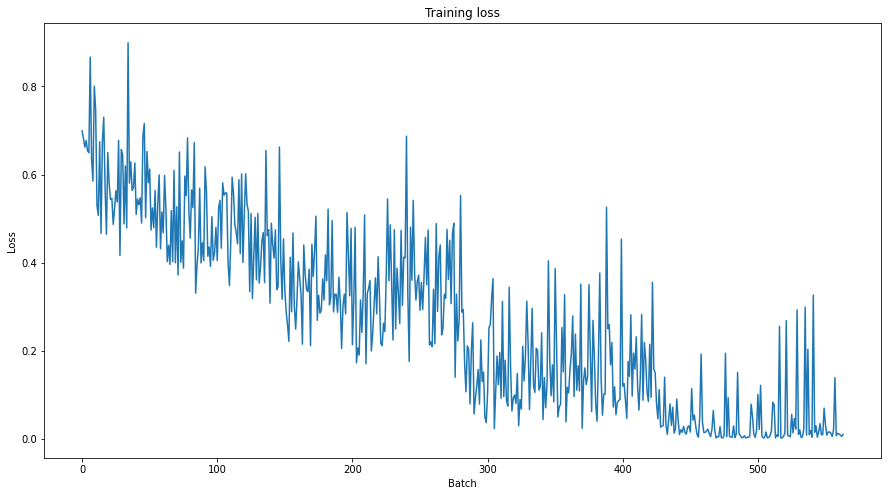

In [68]:
plt.figure(figsize=(15, 8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

Format test set for predictions

In [69]:
test_tweets = test_df.response.values
# We need to add special tokens at the beginning and end of each tweet for BERT to work properly
test_tweets = ["[CLS] " + tweet + " [SEP]" for tweet in test_tweets]
# test_df["label"] = test_df.id.str[8::].astype(int)
test_labels = test_df.id.values

Tokenize test tweets in the same way as training data

In [70]:
test_tokenized_tweets = [tokenizer.tokenize(tweet) for tweet in test_tweets]
MAX_LEN = 128
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(tweet) for tweet in test_tokenized_tweets]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i > 0) for i in seq]
    attention_masks.append(seq_mask)
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)

batch_size = 32
prediction_data = TensorDataset(prediction_inputs, prediction_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Evaluate model on test data

In [71]:
model.eval()
# Tracking variables
predictions, true_labels = [], []

for batch in prediction_dataloader:
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits to CPU
    logits = logits.detach().cpu().numpy()
    # Store predictions and true labels
    predictions.append(logits)

In [72]:
print(predictions)

[array([[ 1.024491  , -1.1654594 ],
       [-2.1641273 ,  2.1185706 ],
       [-2.7248907 ,  2.6679277 ],
       [-3.423502  ,  3.1637907 ],
       [-3.460837  ,  3.1991634 ],
       [-2.4733298 ,  2.4423664 ],
       [ 3.377564  , -3.6542692 ],
       [-2.7154706 ,  2.5308769 ],
       [-1.9843553 ,  1.6217448 ],
       [-2.941667  ,  2.7525706 ],
       [ 3.4493585 , -3.6419458 ],
       [-2.9421601 ,  2.8691    ],
       [ 2.3393412 , -2.3933537 ],
       [ 3.0549107 , -3.2895067 ],
       [-2.5941753 ,  2.5395796 ],
       [ 2.9191484 , -3.262137  ],
       [-3.7285178 ,  3.6441307 ],
       [-2.5190752 ,  2.409114  ],
       [-3.6669002 ,  3.6457312 ],
       [ 2.8748055 , -3.164303  ],
       [ 1.6255927 , -1.5602067 ],
       [-1.5432289 ,  1.4874461 ],
       [ 3.1057584 , -3.3307543 ],
       [ 2.4472914 , -2.4506378 ],
       [-3.334748  ,  3.1184165 ],
       [ 0.55614436, -0.4986384 ],
       [ 2.5639906 , -2.4683328 ],
       [ 3.3790984 , -3.57844   ],
       [-3.8016849 

Flatten output to get predictions in right format

In [73]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
print(flat_predictions)
print(test_labels)
output_dict = {"id": test_labels, "prediction": flat_predictions}
out_df = pd.DataFrame(output_dict)

[0 1 1 ... 1 0 0]
['twitter_1' 'twitter_2' 'twitter_3' ... 'twitter_1798' 'twitter_1799'
 'twitter_1800']


Cast 0/1 to SARCASM and NOT_SARCASM for final output

In [74]:
out_df["prediction"] = out_df.prediction.apply(lambda x: 'SARCASM' if x == 1 else 'NOT_SARCASM')

Save final predictions

In [75]:
out_df.to_csv("answer.txt", index=False, header=False)
